<a href="https://colab.research.google.com/github/NahidurRahaman/Machine_Learning/blob/main/Cross_potato_hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:

!pip install -q torch torchvision timm mlflow pyngrok pytorch-lightning==2.4.0
!pip install -q "huggingface-hub<1.0" "transformers<4.44" torchmetrics==1.4.0 scikit-learn numpy matplotlib seaborn


import os, shutil
if os.path.exists("/root/.cache/huggingface/hub"):
    shutil.rmtree("/root/.cache/huggingface/hub")


import os
import shutil
from pathlib import Path

from PIL import Image


import torch
from torch.utils.data import DataLoader

import pytorch_lightning as pl


from torchvision import datasets, transforms
import timm

import mlflow
import mlflow.pytorch

from pyngrok import ngrok

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:

NGROK_AUTH_TOKEN = "36CLviJ3eedsGnzgPHm7MM9g4De_4tDSxH3CgGEQCytxcXKgX"

MLRUNS_DIR = "/content/drive/MyDrive/BongoDev/Project-1/mlruns"
DATA_ZIP = "/content/drive/MyDrive/BongoDev/Project-1/archive.zip"


EXTRACT_DIR = "/content/drive/MyDrive/BongoDev/Project-1/PLD_3_Classes_256"
IMG_SIZE = 224
BATCH_SIZE = 32

In [47]:
import os
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class PlantDataModule(pl.LightningDataModule):

    def __init__(self, data_dir, batch_size=32, img_size=224):

        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size


        self.train_tfms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(
                brightness=0.2,
                contrast=0.2
            ),
            transforms.ToTensor()
        ])



        self.val_tfms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])


    def setup(self, stage=None):

        train_dir = os.path.join(self.data_dir, "Train")
        val_dir = os.path.join(self.data_dir, "Valid1")
        test_dir = os.path.join(self.data_dir, "Test1")

        if not os.path.exists(train_dir):
            raise FileNotFoundError(f"Expected train folder at {train_dir}")


        self.train_ds = datasets.ImageFolder(train_dir, transform=self.train_tfms)
        self.val_ds = datasets.ImageFolder(val_dir, transform=self.val_tfms) if os.path.exists(val_dir) else None
        self.test_ds = datasets.ImageFolder(test_dir, transform=self.val_tfms) if os.path.exists(test_dir) else None


    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=2
        ) if self.val_ds else None


    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=2
        ) if self.test_ds else None

In [48]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import timm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import Accuracy, F1Score


class TomatoHybridModel(pl.LightningModule):
    def __init__(
        self,
        num_classes=6,
        lr=1e-4,
        weight_decay=1e-5,
        freeze_backbones=True
    ):
        super().__init__()
        self.save_hyperparameters()

        # -------------------------------
        # Metric history (for plotting)
        # -------------------------------
        self.train_acc_history = []
        self.val_acc_history = []
        self.train_loss_history = []
        self.val_loss_history = []

        # -------------------------------
        # Backbones
        # -------------------------------
        # Initialize Swin without features_only=True to access its layers directly
        self.swin = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=True,
            # Removed features_only=True and out_indices
        )

        self.vit = timm.create_model(
            "vit_base_patch16_224",
            pretrained=True,

            num_classes=0
        )

        self.efficientnet = timm.create_model(
            "efficientnetv2_rw_s",
            pretrained=True,
            num_classes=0
        )

        # -------------------------------
        # Freeze backbones (initial)
        # -------------------------------
        if freeze_backbones:
            self.freeze_all_backbones()

        # -------------------------------
        # Learnable attention weights
        # -------------------------------
        self.attn_weights = nn.Parameter(torch.ones(3))

        # -------------------------------
        # Fusion head
        # -------------------------------
        self.fusion = nn.Sequential(
            nn.LazyLinear(1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, num_classes)
        )

        # -------------------------------
        # Loss & Metrics
        # -------------------------------
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_f1 = F1Score(task="multiclass", num_classes=num_classes)

        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes)

    # =========================================================
    # Freeze / Unfreeze utilities (SAFE & ARCH-AWARE)
    # =========================================================
    def freeze_all_backbones(self):
        for m in [self.swin, self.vit, self.efficientnet]:
            for p in m.parameters():
                p.requires_grad = False

    def unfreeze_last_blocks(self):
        # Swin: last stage (now self.swin is the full model)
        for p in self.swin.layers[-1].parameters():
            p.requires_grad = True

        # ViT: last 2 transformer blocks
        for block in self.vit.blocks[-2:]:
            for p in block.parameters():
                p.requires_grad = True

        # EfficientNet: last block
        for p in self.efficientnet.blocks[-1].parameters():
            p.requires_grad = True

    # =========================================================
    # Global Pool
    # =========================================================
    def global_pool(self, x):
        return x.mean(dim=[2, 3]) if x.dim() == 4 else x

    # =========================================================
    # Forward
    # =========================================================
    def forward(self, x):
        # Use forward_features for Swin model now that it's not a FeatureListNet
        swin_feat = self.global_pool(self.swin.forward_features(x))
        vit_feat = self.global_pool(self.vit(x))
        eff_feat = self.global_pool(self.efficientnet(x))

        # Attention fusion (dimension-safe)
        weights = torch.softmax(self.attn_weights, dim=0)
        swin_feat = swin_feat * weights[0]
        vit_feat = vit_feat * weights[1]
        eff_feat = eff_feat * weights[2]

        fused = torch.cat([swin_feat, vit_feat, eff_feat], dim=1)
        return self.fusion(fused)

    # -------------------------------
    # Training / Validation / Test steps
    # -------------------------------
    def training_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.train_acc(logits, y)

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        # Append the epoch's aggregated metrics to the history lists
        self.train_loss_history.append(self.trainer.callback_metrics["train_loss"].item())
        self.train_acc_history.append(self.trainer.callback_metrics["train_acc"].item())

    def validation_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.val_acc(logits, y)
        f1 = self.val_f1(logits, y)

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_f1", f1, prog_bar=True, on_step=False, on_epoch=True)

    def on_validation_epoch_end(self):
        # Append the epoch's aggregated metrics to the history lists
        self.val_loss_history.append(self.trainer.callback_metrics["val_loss"].item())
        self.val_acc_history.append(self.trainer.callback_metrics["val_acc"].item())

    def test_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.test_acc(logits, y)
        f1 = self.test_f1(logits, y)

        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_f1", f1, prog_bar=True, on_step=False, on_epoch=True)

    # -------------------------------
    # Optimizer + Scheduler
    # -------------------------------
    def configure_optimizers(self):
        optimizer = AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = ReduceLROnPlateau(
            optimizer, mode="min", patience=3, factor=0.5
        )
        # FIX: Add 'monitor' key for ReduceLROnPlateau
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}


In [49]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.001,
    mode="min",
    verbose=True
)

In [50]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/content/drive/MyDrive/BongoDev/Project-1/checkpoints",
    filename="best_model1",
    save_top_k=1,
    mode="min",
    verbose=True
)


In [51]:
dm = PlantDataModule(EXTRACT_DIR, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

try:
    dm.setup()
except Exception as e:
    raise RuntimeError(f"Data setup failed: {e}")

num_classes = len(dm.train_ds.classes)
print("Classes:", dm.train_ds.classes)

Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [52]:
print("Preparing data module and model (this will error if your dataset path is wrong)...")
dm = PlantDataModule(EXTRACT_DIR, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

try:
    dm.setup()
except Exception as e:
    raise RuntimeError(f"Data setup failed: {e}")

num_classes = len(dm.train_ds.classes)
print("Classes:", dm.train_ds.classes)

# Pass the IMG_SIZE to the model constructor
model = TomatoHybridModel(num_classes=num_classes)

Preparing data module and model (this will error if your dataset path is wrong)...
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/96.5M [00:00<?, ?B/s]

In [30]:
checkpoints = os.path.join(
    os.getcwd(), "checkpoints", "/content/drive/MyDrive/BongoDev/Project-1/potato_model2.pth"
)

In [31]:
if os.path.exists(checkpoints):
    model.load_state_dict(torch.load(checkpoints))
    print("Model loaded successfully from checkpoints.")

In [55]:
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    precision=16 if torch.cuda.is_available() else 32,
    callbacks=[checkpoint_callback],
    log_every_n_steps=1
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [56]:
trainer.fit(model, dm)

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/BongoDev/Project-1/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | swin         | SwinTransformer    | 28.3 M | train
1 | vit          | VisionTransformer  | 85.8 M | train
2 | efficientnet | EfficientNet       | 22.1 M | train
3 | fusion       | Sequential         | 529 K  | train
4 | criterion    | CrossEntropyLoss   | 0      | train
5 | train_acc    | MulticlassAccuracy | 0      | train
6 | val_acc      | MulticlassAccuracy | 0      | train
7 | val_f1       | MulticlassF1Score  | 0      | train
8 | test_acc     | MulticlassAccuracy | 0      | train
9 | test_f1      | MulticlassF1Score  | 0      | train
  | other 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 103: 'val_loss' reached 0.51697 (best 0.51697), saving model to '/content/drive/MyDrive/BongoDev/Project-1/checkpoints/best_model1-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 206: 'val_loss' reached 0.49838 (best 0.49838), saving model to '/content/drive/MyDrive/BongoDev/Project-1/checkpoints/best_model1-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 309: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 412: 'val_loss' reached 0.49205 (best 0.49205), saving model to '/content/drive/MyDrive/BongoDev/Project-1/checkpoints/best_model1-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 515: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 618: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 721: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 824: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 927: 'val_loss' reached 0.48465 (best 0.48465), saving model to '/content/drive/MyDrive/BongoDev/Project-1/checkpoints/best_model1-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 1030: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 1133: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 1236: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 1339: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 1442: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 1545: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 1648: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 1751: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 1854: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 1957: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 2060: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 2163: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 2266: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 2369: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 2472: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 2575: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 2678: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 2781: 'val_loss' reached 0.47794 (best 0.47794), saving model to '/content/drive/MyDrive/BongoDev/Project-1/checkpoints/best_model1-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 2884: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 2987: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 3090: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [35]:

MODEL_PATH = "/content/drive/MyDrive/BongoDev/Project-1/potato_model1.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Model saved at:", MODEL_PATH)

num_classes = len(dm.train_ds.classes)
num_classes

Model saved at: /content/drive/MyDrive/BongoDev/Project-1/potato_model1.pth


3

In [57]:
import torch
from PIL import Image
import numpy as np

def predict_disease(image_path, model, data_module, device):
    model.eval()
    model.to(device)

    # Load and preprocess the image
    img_pil = Image.open(image_path).convert("RGB")
    input_tensor = data_module.val_tfms(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = torch.softmax(logits, dim=1)

    # Get predicted class and confidence
    predicted_class_idx = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0, predicted_class_idx].item()

    predicted_class_name = data_module.train_ds.classes[predicted_class_idx]

    return predicted_class_name, confidence

In [ ]:
# Example: Using the user's provided screenshot for prediction
example_image_path = "/content/Screenshot 2026-01-23 234242.png"

predicted_disease, confidence = predict_disease(example_image_path, model, dm, device)

print(f"Predicted Disease: {predicted_disease.replace('_', ' ').title()}")
print(f"Confidence: {confidence:.2%}")

# Example 2: Using one of the dataset images
example_image_path_2 = "/content/drive/MyDrive/Project-1/image/narrow_brown.jpg"

predicted_disease_2, confidence_2 = predict_disease(example_image_path_2, model, dm, device)

print(f"\nPredicted Disease (Image 2): {predicted_disease_2.replace('_', ' ').title()}")
print(f"Confidence (Image 2): {confidence_2:.2%}")

In [58]:
trainer.test(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9235880374908447     │
│          test_f1          │    0.9235880374908447     │
│         test_loss         │    0.4801305830478668     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4801305830478668,
  'test_acc': 0.9235880374908447,
  'test_f1': 0.9235880374908447}]

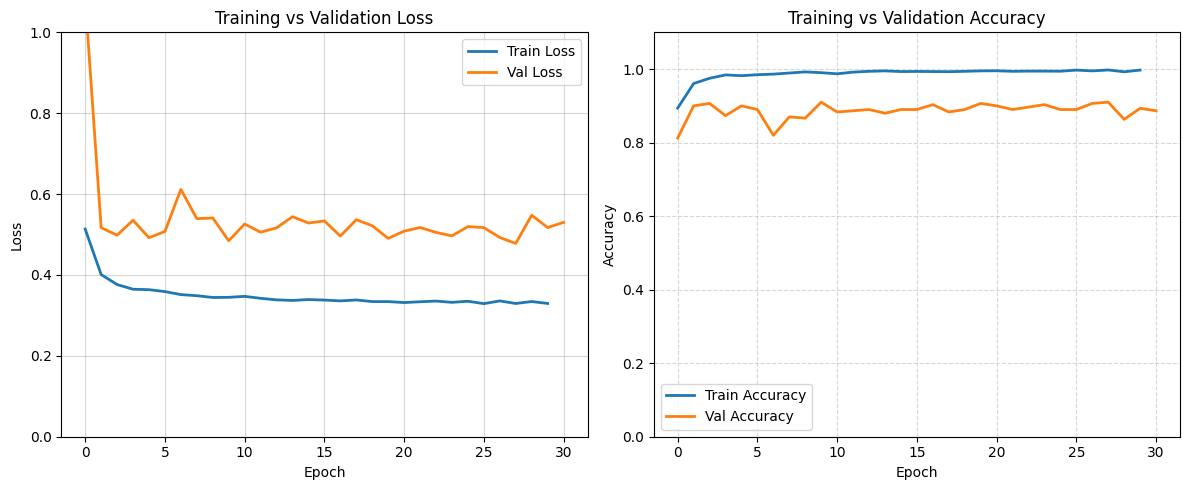

In [74]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 5))

# ---------------------------
# LOSS CURVE
# ---------------------------
plt.subplot(1, 2, 1)
plt.plot(model.train_loss_history, linewidth=2, label="Train Loss")
plt.plot(model.val_loss_history,linewidth=2, label="Val Loss")
plt.ylim(0,1.0)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.5)

# ---------------------------
# ACCURACY CURVE
# ---------------------------
plt.subplot(1, 2, 2)
plt.plot(model.train_acc_history, linewidth=2, label="Train Accuracy")
plt.plot(model.val_acc_history, linewidth=2, label="Val Accuracy")
plt.ylim(0, 1.1) # Adjusted y-axis limit for better visibility
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

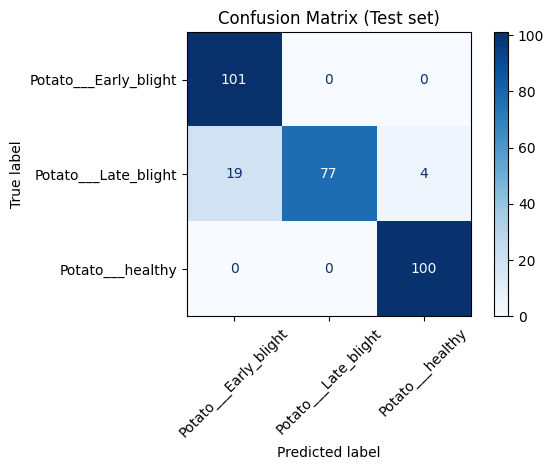

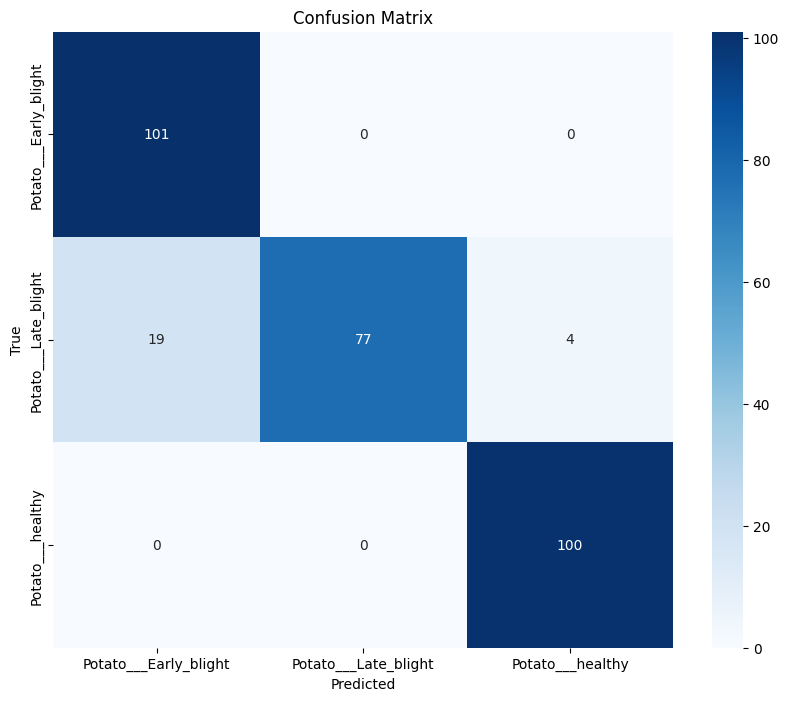

In [63]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
model.to('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_labels = []

test_dl = dm.test_dataloader()
if test_dl is None:
    print("No test set found → using validation set")
    test_dl = dm.val_dataloader()

with torch.no_grad():
    for batch in test_dl:
        x, y = batch
        x = x.to(model.device)
        logits = model(x)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dm.train_ds.classes)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Test set)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dm.train_ds.classes,
            yticklabels=dm.train_ds.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [40]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=2f53899810086ce03c20d7e9fbb78b88b8b4638a8dfa90aebcf09707fee1b86f
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [64]:
import numpy as np
import torch
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

model.eval()
model_device = next(model.parameters()).device
model.to(model_device)

all_labels = []
all_logits = []


current_dataloader = dm.test_dataloader()
if current_dataloader is None:
    print("No test set found, using validation set for ROC curve calculation.")
    current_dataloader = dm.val_dataloader()
    if current_dataloader is None:
        raise ValueError("Neither validation nor test dataloader is available. Cannot compute ROC curve.")
else:
    print("Using test set for ROC curve calculation.")

with torch.no_grad():
    for inputs, targets in current_dataloader:
        inputs = inputs.to(model_device)
        logits = model(inputs)
        all_logits.append(logits.cpu())
        all_labels.append(targets.cpu())


all_logits = torch.cat(all_logits).numpy()
all_labels = torch.cat(all_labels).numpy()


num_classes = len(dm.train_ds.classes)
class_names = dm.train_ds.classes


y_true = label_binarize(all_labels, classes=list(range(num_classes)))

y_score = torch.softmax(torch.tensor(all_logits), dim=1).numpy()

print(f"Collected {len(all_labels)} samples for ROC analysis.")
print(f"Shape of y_true: {y_true.shape}")
print(f"Shape of y_score: {y_score.shape}")

Using test set for ROC curve calculation.
Collected 301 samples for ROC analysis.
Shape of y_true: (301, 3)
Shape of y_score: (301, 3)


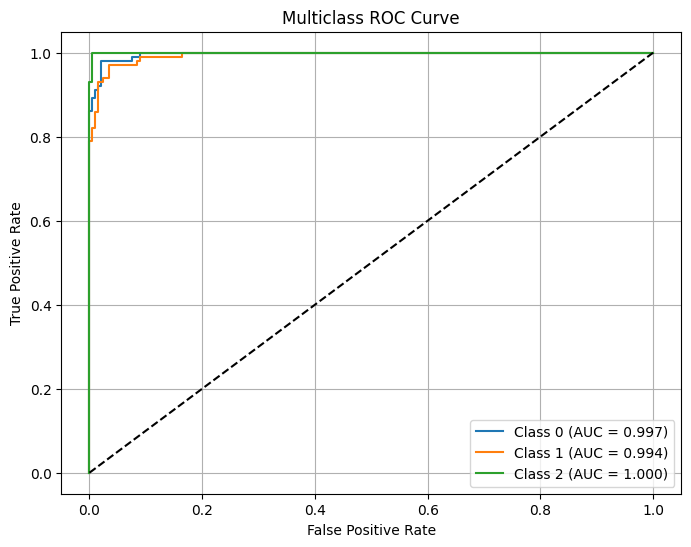

In [65]:
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        label=f"Class {i} (AUC = {roc_auc:.3f})"
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [42]:
import numpy as np
import torch
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

model.eval()
model_device = next(model.parameters()).device
model.to(model_device)

all_labels = []
all_logits = []


current_dataloader = dm.test_dataloader()
if current_dataloader is None:
    print("No test set found, using validation set for ROC curve calculation.")
    current_dataloader = dm.val_dataloader()
    if current_dataloader is None:
        raise ValueError("Neither validation nor test dataloader is available. Cannot compute ROC curve.")
else:
    print("Using test set for ROC curve calculation.")

with torch.no_grad():
    for inputs, targets in current_dataloader:
        inputs = inputs.to(model_device)
        logits = model(inputs)
        all_logits.append(logits.cpu())
        all_labels.append(targets.cpu())


all_logits = torch.cat(all_logits).numpy()
all_labels = torch.cat(all_labels).numpy()


num_classes = len(dm.train_ds.classes)
class_names = dm.train_ds.classes


y_true = label_binarize(all_labels, classes=list(range(num_classes)))

y_score = torch.softmax(torch.tensor(all_logits), dim=1).numpy()

print(f"Collected {len(all_labels)} samples for ROC analysis.")
print(f"Shape of y_true: {y_true.shape}")
print(f"Shape of y_score: {y_score.shape}")

Using test set for ROC curve calculation.
Collected 301 samples for ROC analysis.
Shape of y_true: (301, 3)
Shape of y_score: (301, 3)


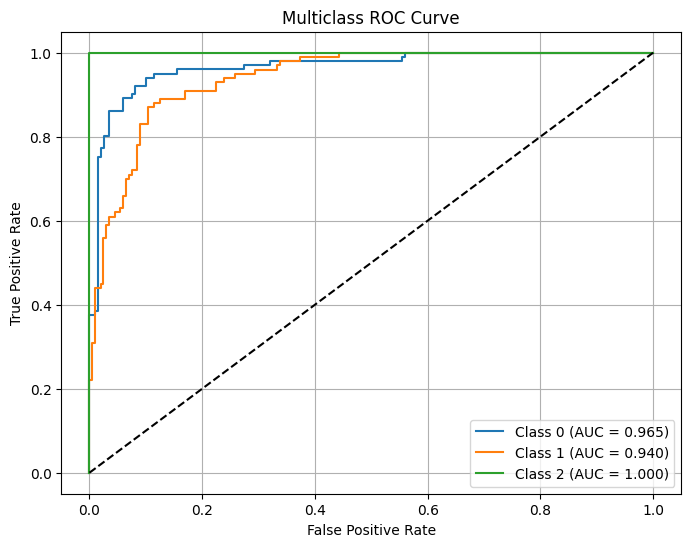

In [43]:
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        label=f"Class {i} (AUC = {roc_auc:.3f})"
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Classification Report (Precision, Recall, F1-Score)
              precision    recall  f1-score   support

Early_Blight     0.9962    0.9962    0.9962       263
     Healthy     0.9902    1.0000    0.9951       202
 Late_Blight     1.0000    0.9917    0.9958       241

    accuracy                         0.9958       706
   macro avg     0.9955    0.9960    0.9957       706
weighted avg     0.9958    0.9958    0.9958       706



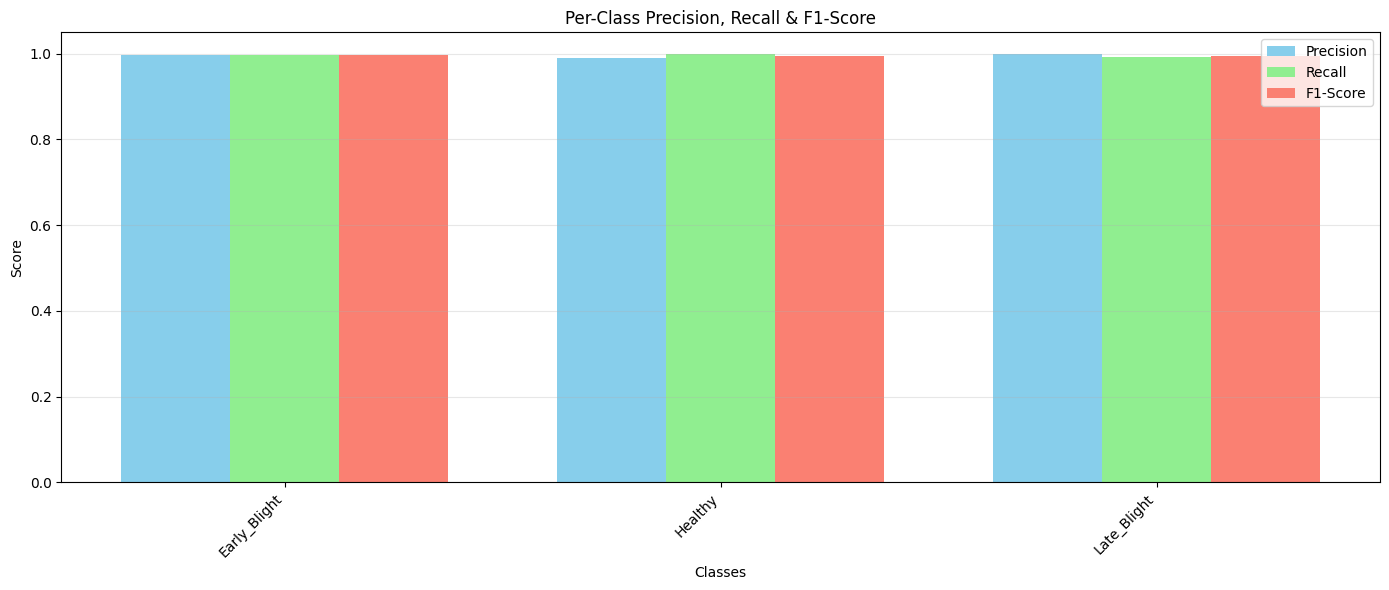

<Figure size 1200x1000 with 0 Axes>

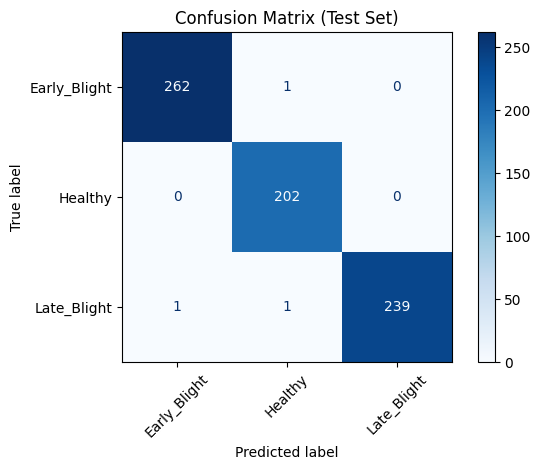


Summary Averages
Macro Average    → Precision: 0.9955 | Recall: 0.9960 | F1: 0.9957
Weighted Average → Precision: 0.9958 | Recall: 0.9958 | F1: 0.9958


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import torch

model.eval()
all_preds = []
all_labels = []
all_probs = []  # optional for ROC if needed later

test_dl = dm.test_dataloader()  # or dm.val_dataloader() if no test set

with torch.no_grad():
    for batch in test_dl:
        x, y = batch
        x = x.to(model.device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs)


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

class_names = dm.train_ds.classes

print("\n" + "="*60)
print("Classification Report (Precision, Recall, F1-Score)")
print("="*60)
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print(report)

precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)

plt.figure(figsize=(14, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1, width, label='F1-Score', color='salmon')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Per-Class Precision, Recall & F1-Score')
plt.xticks(x, class_names, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(12, 10))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print("\n" + "="*60)
print("Summary Averages")
print("="*60)
print(f"Macro Average    → Precision: {precision_macro:.4f} | Recall: {recall_macro:.4f} | F1: {f1_macro:.4f}")
print(f"Weighted Average → Precision: {precision_weighted:.4f} | Recall: {recall_weighted:.4f} | F1: {f1_weighted:.4f}")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from pytorch_grad_cam import GradCAM, ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
def vit_swin_reshape_transform(tensor):
    # If the input is a list (e.g., from FeatureListNet with features_only=True)
    # extract the actual tensor from it.
    if isinstance(tensor, list):
        tensor = tensor[0] # Assuming it's a list with a single tensor from out_indices=[3]

    if tensor.ndim == 4: # Swin FeatureListNet output (B, C, H_spatial, W_spatial)
        # This is already in (B, C, H, W) format, which ScoreCAM's upsampling expects.
        return tensor

    elif tensor.ndim == 3: # ViT tokens output (B, N, C)
        B, N, C = tensor.shape
        # Infer spatial dimensions (H, W) from N
        # N could be 1 + H*W (with CLS token) or H*W (without CLS token)

        H = W = 0
        # Try to infer H, W assuming N is H*W or 1+H*W
        if int(N**0.5) * int(N**0.5) == N: # N is a perfect square, assume no CLS token
            H = W = int(N**0.5)
            # Reshape from (B, N, C) to (B, C, H, W)
            return tensor.permute(0, 2, 1).reshape(B, C, H, W)
        elif N > 1 and int((N-1)**0.5) * int((N-1)**0.5) == (N-1): # N-1 is a perfect square, assume CLS token
            H = W = int((N - 1)**0.5)
            # Remove CLS token, then reshape from (B, N-1, C) to (B, C, H, W)
            return tensor[:, 1:, :].permute(0, 2, 1).reshape(B, C, H, W)
        else:
            raise ValueError(f"Cannot infer 2D spatial dimensions from 3D tensor with N={N}. Shape: {tensor.shape}")
    else:
        raise ValueError(f"Unexpected tensor dimensions for reshape_transform: {tensor.ndim}. Shape: {tensor.shape}")

In [ ]:
import torch
from pytorch_grad_cam import GradCAM, ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# --------------------------------------------------
# Device & model state
# --------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# IMPORTANT: Enable gradients for Grad-CAM
for p in model.parameters():
    p.requires_grad = True

# --------------------------------------------------
# Swin Transformer CAM (Score-CAM)
# --------------------------------------------------
swin_cam = ScoreCAM(
    model=model,
    target_layers=[model.swin.layers[-1].blocks[-1]],
    reshape_transform=vit_swin_reshape_transform
)

# --------------------------------------------------
# Vision Transformer CAM (Score-CAM)
# --------------------------------------------------
vit_cam = ScoreCAM(
    model=model,
    target_layers=[model.vit.blocks[-1]],
    reshape_transform=vit_swin_reshape_transform
)

# --------------------------------------------------
# EfficientNet CAM (Grad-CAM)
# --------------------------------------------------
eff_cam = GradCAM(
    model=model,
    target_layers=[model.efficientnet.conv_head] # Corrected target layer to conv_head
)



Processing image: /content/drive/MyDrive/Project-1/image/RS_EarlyB7577.JPG
Current global IMG_SIZE: 224
DataModule's img_size: 224
Input tensor shape before CAM: torch.Size([1, 3, 224, 224])


100%|██████████| 48/48 [00:15<00:00,  3.12it/s]


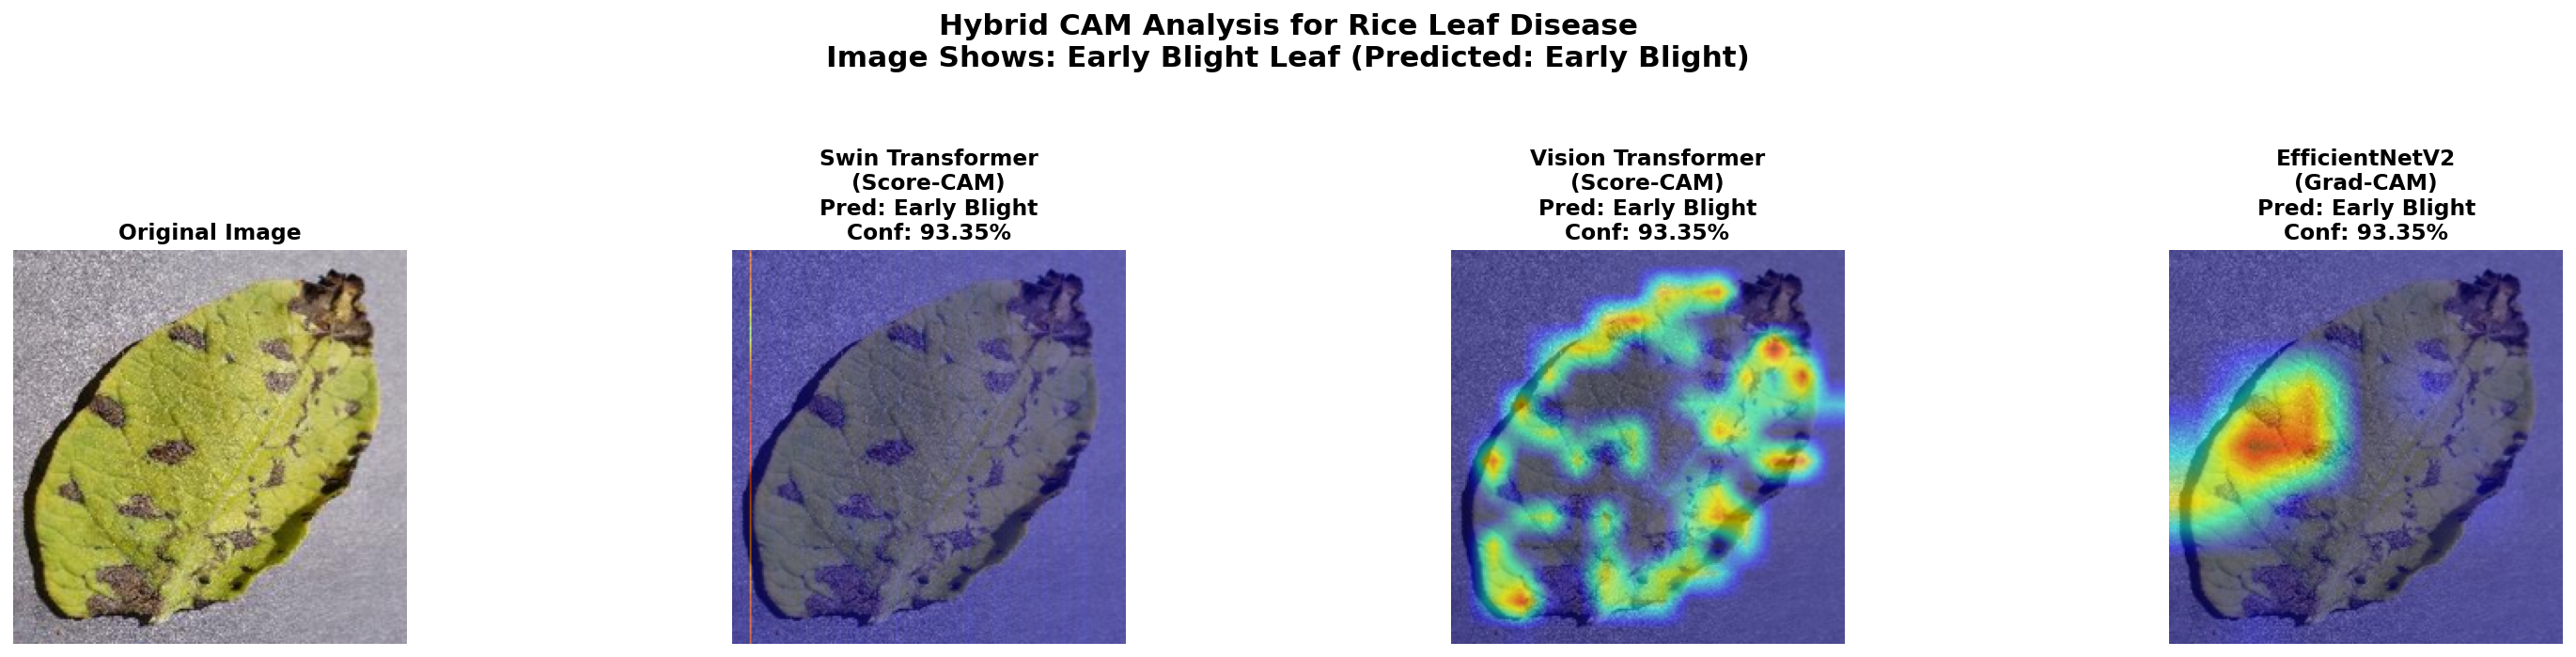


Processing image: /content/drive/MyDrive/Project-1/image/Healthy_43.jpg
Current global IMG_SIZE: 224
DataModule's img_size: 224
Input tensor shape before CAM: torch.Size([1, 3, 224, 224])


100%|██████████| 48/48 [00:15<00:00,  3.13it/s]


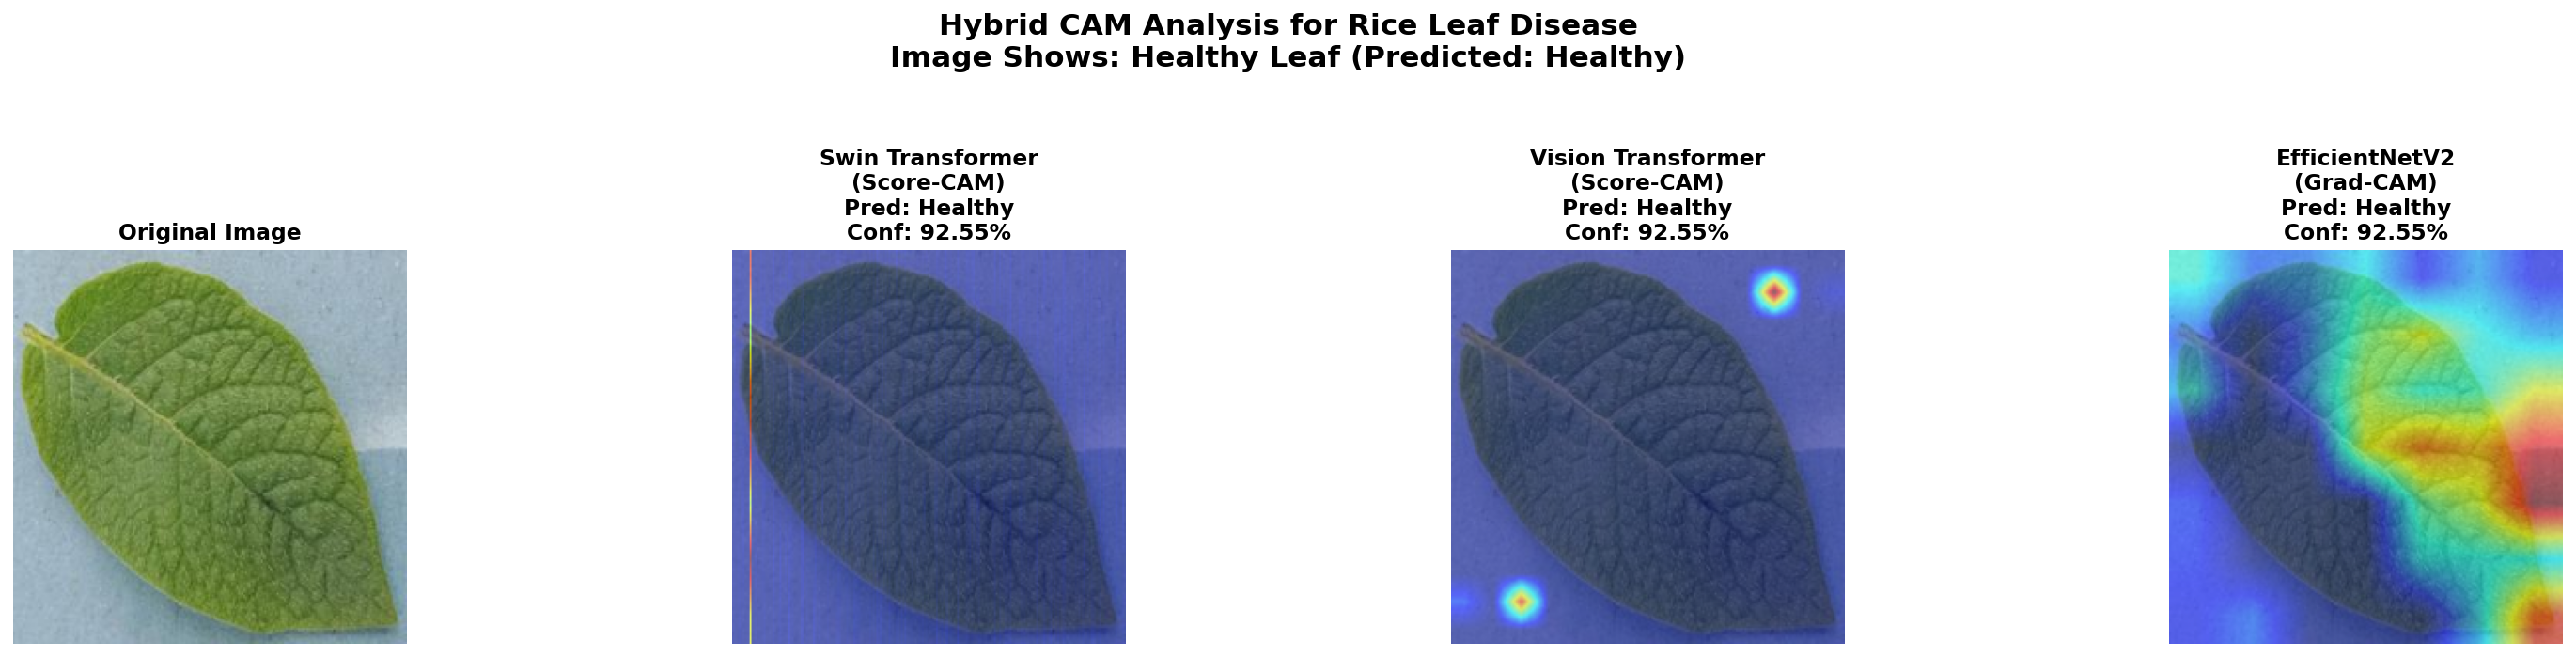


Processing image: /content/drive/MyDrive/Project-1/image/RS_LB4101.JPG
Current global IMG_SIZE: 224
DataModule's img_size: 224
Input tensor shape before CAM: torch.Size([1, 3, 224, 224])


100%|██████████| 48/48 [00:15<00:00,  3.08it/s]


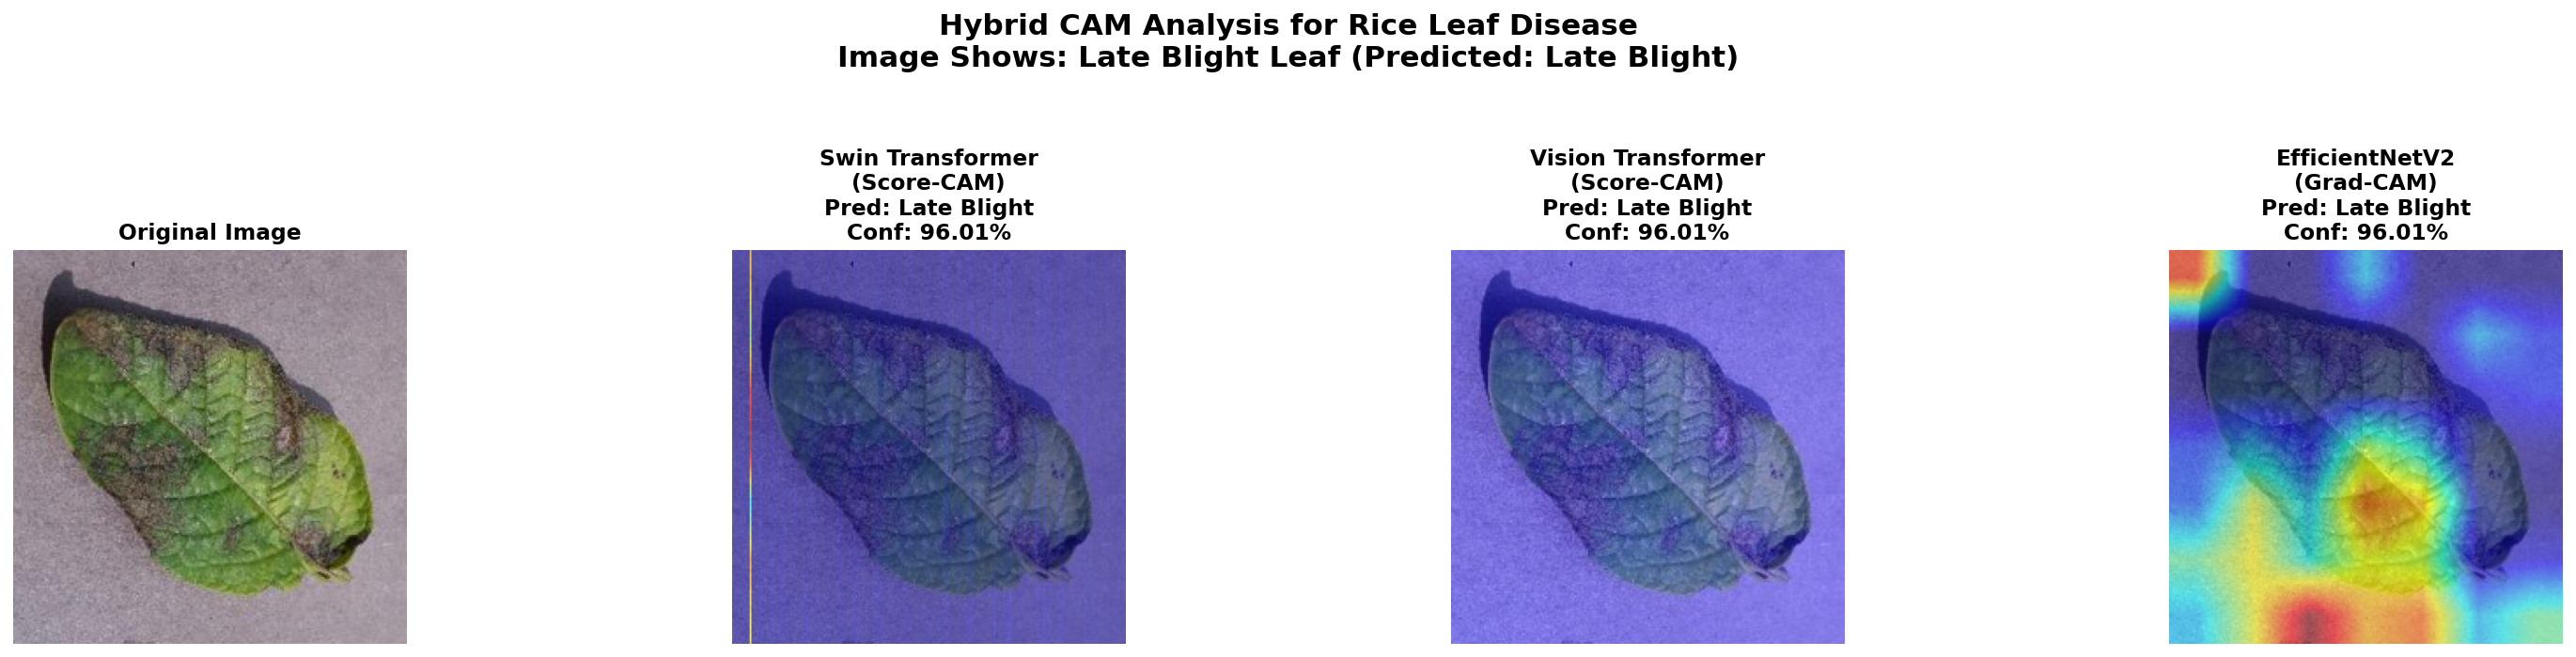

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Define a list of image paths to process ---
# >>> EDIT THESE PATHS TO YOUR OWN IMAGES <<<
image_paths = [
    "/content/drive/MyDrive/Project-1/image/RS_EarlyB7577.JPG",
    "/content/drive/MyDrive/Project-1/image/Healthy_43.jpg",
    "/content/drive/MyDrive/Project-1/image/RS_LB4101.JPG"
]
# >>> EDIT THESE LABELS TO MATCH YOUR IMAGE DESCRIPTIONS <<<
image_labels = [
    "Early Blight Leaf",
    "Healthy Leaf",
    "Late Blight Leaf"
]

def norm(cam):
    return (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

# Move model to device explicitly before processing any images
# This is a defensive step to ensure the model is on GPU
model.to(device)
model.eval() # Ensure model is in evaluation mode


# --- Iterate through each image and generate/plot CAMs ---
for idx, img_path in enumerate(image_paths):
    try:
        print(f"\nProcessing image: {img_path}")
        print(f"Current global IMG_SIZE: {IMG_SIZE}")
        print(f"DataModule's img_size: {dm.img_size}")

        img_pil = Image.open(img_path).convert("RGB")
        input_tensor = dm.val_tfms(img_pil).unsqueeze(0).to(device)

        print(f"Input tensor shape before CAM: {input_tensor.shape}")

        # prediction
        with torch.no_grad():
            logits = model(input_tensor)
            pred_idx = logits.argmax(dim=1).item()
            confidence = torch.softmax(logits, dim=1)[0, pred_idx].item()
        pred_class_name = dm.train_ds.classes[pred_idx] # Get class name here

        targets = [ClassifierOutputTarget(pred_idx)]

        # CAMs
        cam_swin = swin_cam(input_tensor, targets)[0]
        cam_vit  = vit_cam(input_tensor, targets)[0]
        cam_eff  = eff_cam(input_tensor, targets)[0]

        cam_swin_norm = norm(cam_swin)
        cam_vit_norm  = norm(cam_vit)
        cam_eff_norm  = norm(cam_eff)

        img_np = np.array(img_pil.resize((IMG_SIZE, IMG_SIZE))) / 255.0 # Ensure display image is also resized correctly

        vis_swin = show_cam_on_image(img_np, cam_swin_norm, use_rgb=True)
        vis_vit  = show_cam_on_image(img_np, cam_vit_norm, use_rgb=True)
        vis_eff  = show_cam_on_image(img_np, cam_eff_norm, use_rgb=True)

        # --- Plot for the current image ---
        fig, axes = plt.subplots(1, 4, figsize=(22, 5), dpi=140)

        axes[0].imshow(img_np)
        axes[0].set_title("Original Image", fontsize=12, fontweight='bold')
        axes[0].axis("off")

        # Function to add arrow and title to CAM plots (modified to remove arrow)
        def add_cam_details(ax, vis_cam, cam_norm, title_text, pred_class_name, confidence):
            ax.imshow(vis_cam)
            ax.set_title(f"{title_text}\nPred: {pred_class_name.replace('_', ' ').title()}\nConf: {confidence:.2%}",
                         fontsize=12, fontweight='bold')
            ax.axis("off")

        add_cam_details(axes[1], vis_swin, cam_swin_norm, "Swin Transformer\n(Score-CAM)", pred_class_name, confidence)
        add_cam_details(axes[2], vis_vit, cam_vit_norm, "Vision Transformer\n(Score-CAM)", pred_class_name, confidence)
        add_cam_details(axes[3], vis_eff, cam_eff_norm, "EfficientNetV2\n(Grad-CAM)", pred_class_name, confidence)


        fig.suptitle(
            f"Hybrid CAM Analysis for Rice Leaf Disease\nImage Shows: {image_labels[idx]} (Predicted: {pred_class_name.replace('_', ' ').title()})",
            fontsize=16,
            fontweight="bold",
            y=1.02 # Adjust vertical position of main title
        )

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to prevent suptitle overlap
        plt.show()
    except FileNotFoundError:
        print(f"Error: Image not found at path: {img_path}. Please check the path and try again.")
    except Exception as e:
        print(f"An unexpected error occurred while processing {img_path}: {e}")
        import traceback
        traceback.print_exc()